In [2]:
import os,sys
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time as time

sys.path.append('../utils')
import affinity_maturation_utilities as util

## Compile individual round alignments into a single based on a reference alignment

In [3]:
parent_dir =  'AT110'
suffix = 'correct_nb_dedup_H.csv'

campaign_A_dict = {
                'MACS': os.path.join(parent_dir, f'MACS/bcsplit_protein/AT110-MACS_{suffix}'),
                'FACS1': os.path.join(parent_dir, f'FACS1/bcsplit_protein/AT110-FACS1_{suffix}'),
                'FACS2': os.path.join(parent_dir, f'FACS2/bcsplit_protein/AT110-FACS2_{suffix}')
    }
wt_afnm = os.path.join(parent_dir, 'aligned_WT_sequence.csv')

save_dir = os.path.join(parent_dir, 'all_rounds')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

save_fnm = os.path.join(save_dir, 'AT110_MACS_FACS1_FACS2_H.csv')

In [4]:
util.compile_rnd_alignments(campaign_A_dict, wt_afnm, save_fnm)

compiling alignments: 100%|██████████| 3/3 [00:43<00:00, 14.52s/it]


### Processing

Filtering parameters:
- fil: raw count threshold. Only sequences that are at least above this tr in at least one of the sequencing rounds are considered for training.
- fil_abund: the floor set to normalized abundance values (1 count per million by default)
- norm: whether to normalize to CPM

Extracting alignment took: 176.72s


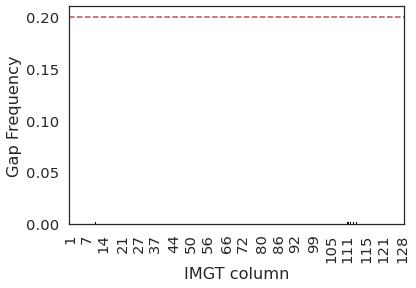

Index([], dtype='object')
total reads:
MACS_ct     922141
FACS1_ct    554585
FACS2_ct    430342
dtype: int64
average reads: 635689.3
Number of unique reads:
MACS_hasread     8543
FACS1_hasread    9331
FACS2_hasread    6126
dtype: int64


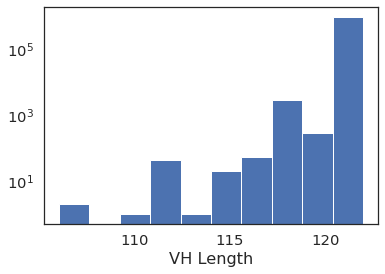

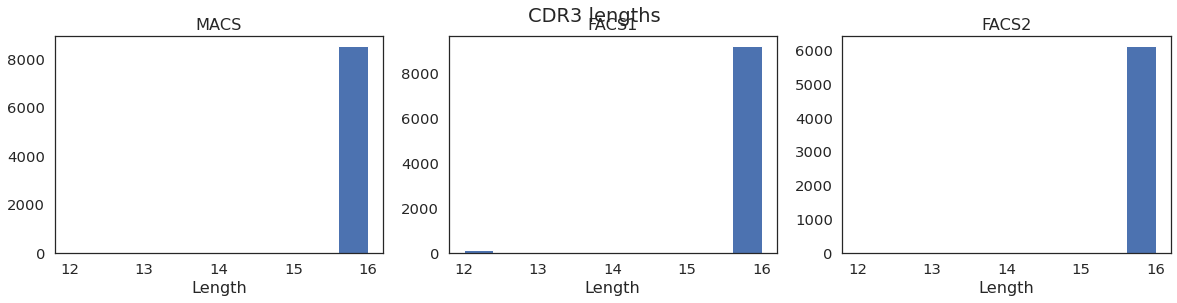

FACS1_MACS
16858 seqs total
0 seqs not assigned (low confidence)
8154 seqs not enriched
8704 seqs enriched

FACS2_MACS
13871 seqs total
0 seqs not assigned (low confidence)
8202 seqs not enriched
5669 seqs enriched

FACS2_FACS1
14159 seqs total
0 seqs not assigned (low confidence)
8439 seqs not enriched
5720 seqs enriched



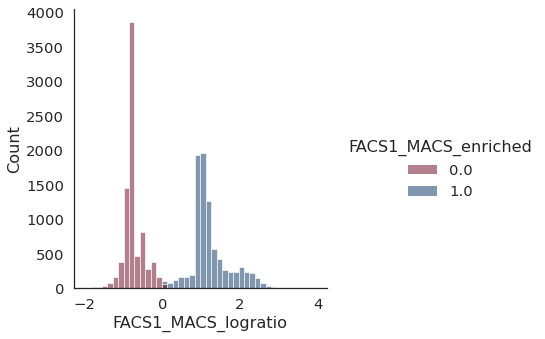

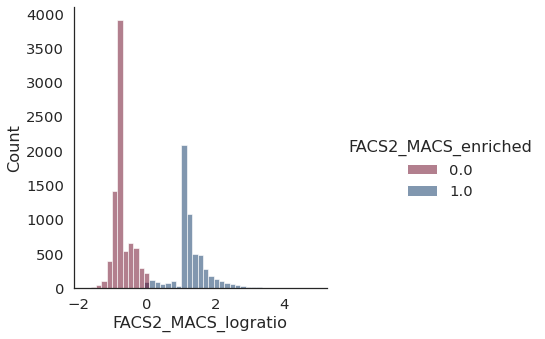

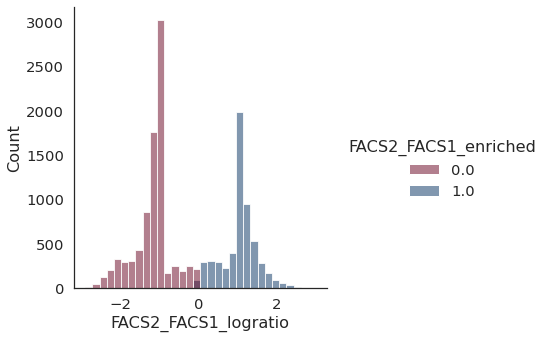

In [6]:
#import alignment
fil = 5 
fil_abund = 1
norm = True

#fnm of the alignment you're accessing
parent_dir = 'AT110'
align_name = 'all_rounds/AT110_MACS_FACS1_FACS2_H.csv'
round_labs = ['MACS', 'FACS1', 'FACS2']
#directory where you will save the ML ready dfs
dir_name = f'V1'

#make folders
align_fnm = os.path.join(parent_dir, align_name)
save_dir = os.path.join(parent_dir, dir_name)
fig_dir = os.path.join(save_dir, 'figures')
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)

#import data
Y_df, X_df, imgt_labels = util.import_from_alignment(align_fnm, save_dir, dir_name,
                                                    round_labs,
                                                     **{'plot_gaps':True})

#normalize counts
Y_df = util.process_round_info(Y_df, round_labs,
                               normalize=norm, fill_count=fil, fill_abund=fil_abund,
                               new_norm=True)

#format
X_df = X_df.set_index('seq_ID').loc[Y_df['seq_ID']]
Y_df = Y_df.set_index('seq_ID')

#Remove any really short sequences
lengths = X_df['FullSeq_nogaps'].apply(len)

plt.hist(lengths)
plt.yscale('log')
plt.xlabel('VH Length')
plt.show()

#filter lengths
min_length=110

X_df = X_df[lengths > min_length]
Y_df = Y_df[lengths > min_length]

#calculate lengths

#plot CDR lens for all rounds
round_labs = ['MACS', 'FACS1', 'FACS2']

cdr = 3
lens = X_df[f'CDR{cdr}_nogaps'].apply(len)
fig, axes = plt.subplots(1,len(round_labs), figsize=(20,4))
for ii,r in enumerate(round_labs):
    tmp = lens.loc[Y_df[f'{r}_hasread']]
    axes[ii].hist(tmp)
    axes[ii].set_xlabel('Length')
    axes[ii].set_title(r)
fig.suptitle(f'CDR{cdr} lengths')
plt.show()

#binarize the rounds
sns.set_theme(style='white', font_scale=1.35)
round_pairs = list(Y_df.columns[Y_df.columns.str.contains('logratio')].str.strip('_logratio'))
for rp in round_pairs:
    #to binarize manually
    Y_df = util.binarize_enrichment(Y_df, rp, plot_check=True,
                              assignment_method= 'manual', assignment_tr=(0,0),
                                   only_ovlp=False, new_norm=True,
                                   plot_kwargs={'save_dir':fig_dir})

#make a separate copy of dfs that will be used in data splits
insets = Y_df[ [f'{p}_split' for p in round_pairs] ].isna().sum(axis=1)
X_df_s = X_df.loc[insets < len(round_pairs)]
Y_df_s = Y_df.loc[insets < len(round_pairs)]

sub_nm = ''
#save seqs
x_savenm = os.path.join(save_dir, f'X_{sub_nm}.csv')
X_df_s.to_csv(x_savenm)
#save phenotypes
y_savenm = os.path.join(save_dir, f'Y_{sub_nm}.csv')
Y_df_s.to_csv(y_savenm)

SAVEALL=True
if SAVEALL:
    sub_nm = 'all'
    #save seqs
    x_savenm = os.path.join(save_dir, f'X_{sub_nm}.csv')
    X_df.to_csv(x_savenm)
    #save phenotypes
    y_savenm = os.path.join(save_dir, f'Y_{sub_nm}.csv')
    Y_df.to_csv(y_savenm)
